In [13]:
!pip install swifter
!pip install scikit-optimize

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import swifter
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Cell 2: Load Dataset and Preprocess


In [14]:
# File path to the dataset
file_path = '/content/drive/MyDrive/Dissertation Project/modified_news_dataset.csv'

# Load the dataset
data = pd.read_csv(file_path)

# Drop the 'title' column if it exists
data = data.drop(columns=['title'], errors='ignore')

# Handle missing values
data = data.fillna('')

# Precompute stopwords and initialize lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function for text preprocessing using lemmatization
def preprocess_text_lemmatizer(text):
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase once
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]  # Remove non-alphabetic tokens and stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize the tokens
    return ' '.join(tokens)

# Apply preprocessing in parallel using swifter
data['text'] = data['text'].swifter.apply(preprocess_text_lemmatizer)


Pandas Apply:   0%|          | 0/44898 [00:00<?, ?it/s]

Cell 3: Visualization (Word Clouds and Distribution)


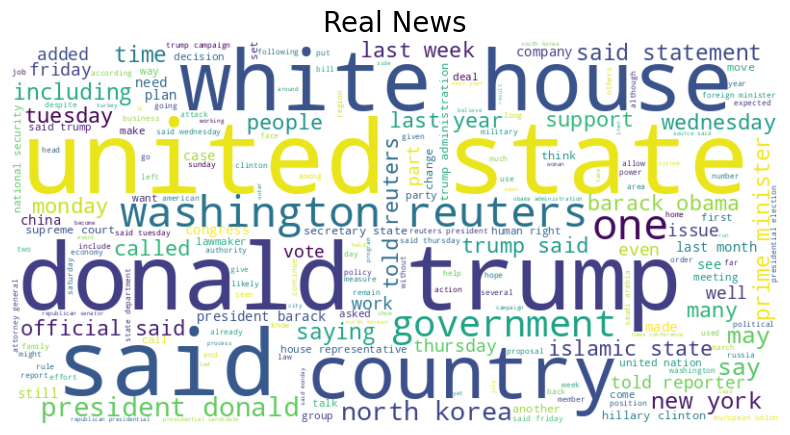

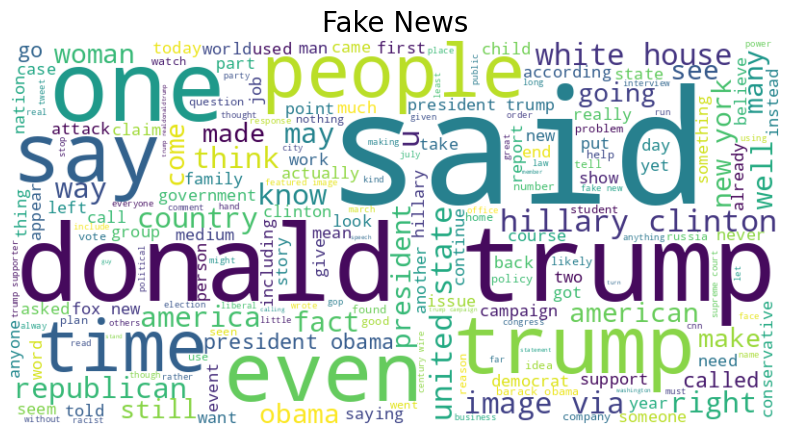

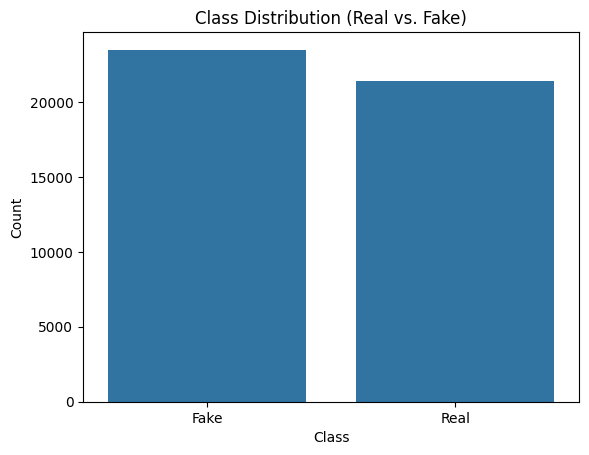

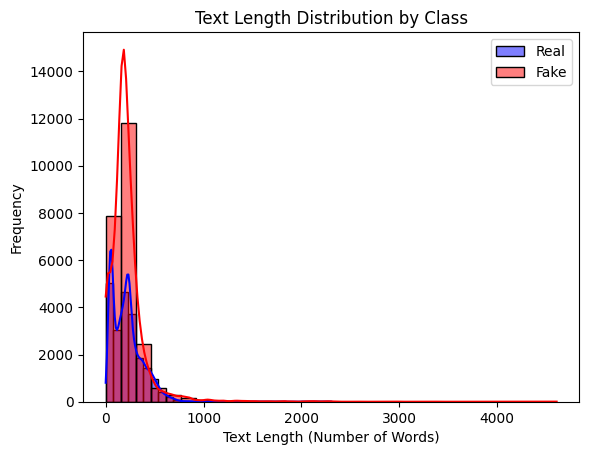

In [15]:
# Separate real and fake news for visualization
real_news = data[data['label'] == 1]
fake_news = data[data['label'] == 0]

# Function to generate and display word clouds
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, size=20)
    plt.axis('off')
    plt.show()

# Generate word clouds for real and fake news
generate_wordcloud(' '.join(real_news['text']), 'Real News')
generate_wordcloud(' '.join(fake_news['text']), 'Fake News')

# Class Distribution
sns.countplot(x='label', data=data)
plt.title('Class Distribution (Real vs. Fake)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Fake', 'Real'])
plt.show()

# Text Length Distribution by Class
data['text_length'] = data['text'].apply(lambda x: len(x.split()))
sns.histplot(data[data['label'] == 1]['text_length'], color='blue', label='Real', kde=True, bins=30)
sns.histplot(data[data['label'] == 0]['text_length'], color='red', label='Fake', kde=True, bins=30)
plt.title('Text Length Distribution by Class')
plt.xlabel('Text Length (Number of Words)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


Cell 4: Train-Test Split and Vectorization


In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

# Vectorize the text using TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


Cell 5: Naive Bayes Model


Naive Bayes Model:
Accuracy: 0.9292
Confusion Matrix:
 [[4319  288]
 [ 348 4025]]
Classification Report:
               precision    recall  f1-score   support

        Fake       0.93      0.94      0.93      4607
        Real       0.93      0.92      0.93      4373

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



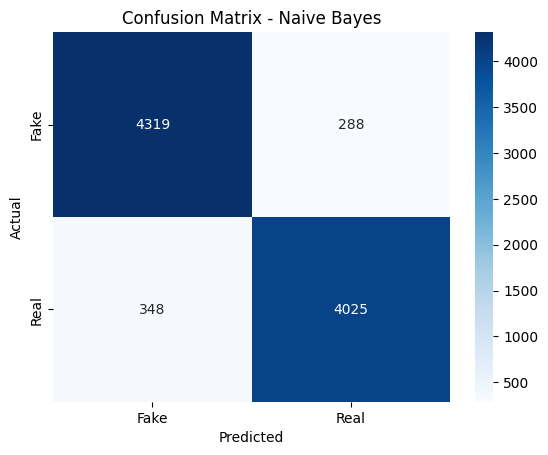

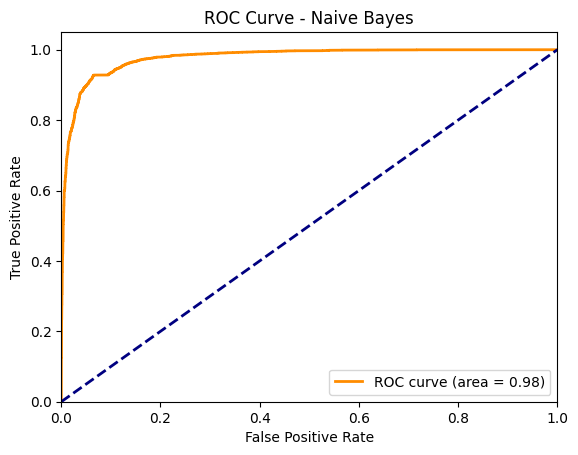

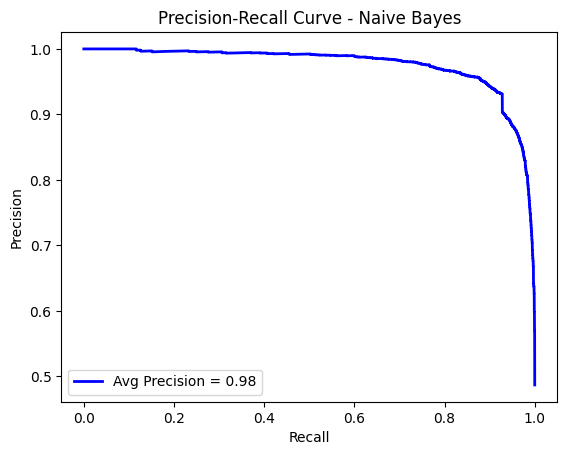

In [29]:
### Naive Bayes Model with Fixed Hyperparameter ###
nb_model = MultinomialNB(alpha=1.0)  # Set alpha manually

# Fit the model
nb_model.fit(X_train_vec, y_train)

# Make predictions
y_pred_nb = nb_model.predict(X_test_vec)
y_pred_nb_prob = nb_model.predict_proba(X_test_vec)[:, 1]

# Evaluate Naive Bayes Model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
report_nb = classification_report(y_test, y_pred_nb, target_names=['Fake', 'Real'])

print("Naive Bayes Model:")
print(f'Accuracy: {accuracy_nb:.4f}')
print('Confusion Matrix:\n', conf_matrix_nb)
print('Classification Report:\n', report_nb)

# Plot Confusion Matrix
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

# ROC Curve for Naive Bayes
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_nb_prob)
roc_auc_nb = auc(fpr_nb, tpr_nb)
plt.figure()
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_nb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve for Naive Bayes
precision_nb, recall_nb, _ = precision_recall_curve(y_test, y_pred_nb_prob)
avg_precision_nb = average_precision_score(y_test, y_pred_nb_prob)
plt.figure()
plt.plot(recall_nb, precision_nb, lw=2, color='blue', label=f'Avg Precision = {avg_precision_nb:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Naive Bayes')
plt.legend(loc='lower left')
plt.show()

Cell 6: K-Nearest Neighbors Model


KNN Model:
Accuracy: 0.8598
Confusion Matrix:
 [[3664  943]
 [ 316 4057]]
Classification Report:
               precision    recall  f1-score   support

        Fake       0.92      0.80      0.85      4607
        Real       0.81      0.93      0.87      4373

    accuracy                           0.86      8980
   macro avg       0.87      0.86      0.86      8980
weighted avg       0.87      0.86      0.86      8980



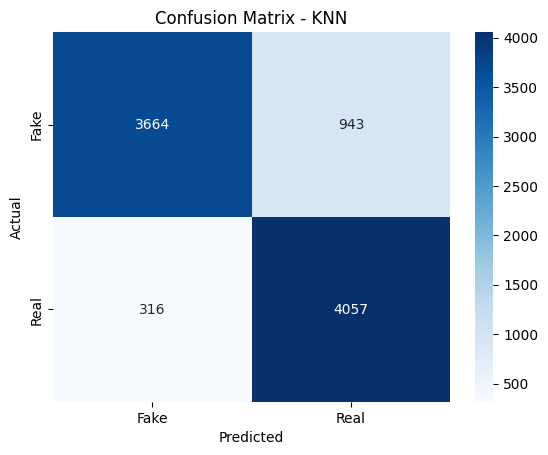

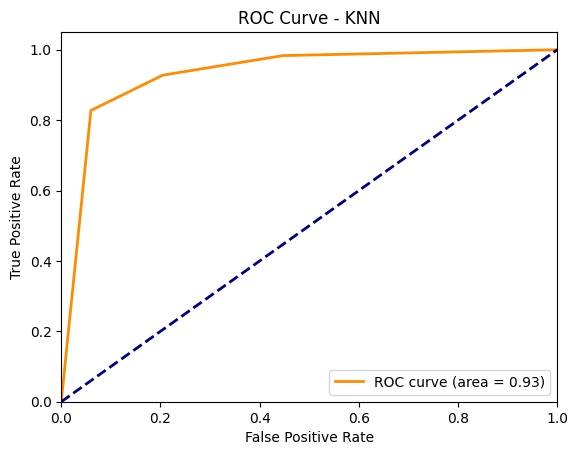

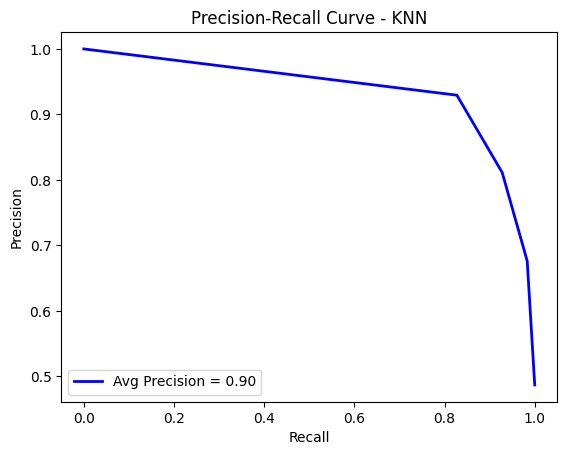

In [30]:
### KNN Model ###
knn_model = KNeighborsClassifier(n_neighbors=3, metric='cosine')
knn_model.fit(X_train_vec, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test_vec)
y_pred_knn_prob = knn_model.predict_proba(X_test_vec)[:, 1]

# Evaluate KNN Model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn, target_names=['Fake', 'Real'])

print("KNN Model:")
print(f'Accuracy: {accuracy_knn:.4f}')
print('Confusion Matrix:\n', conf_matrix_knn)
print('Classification Report:\n', report_knn)

# Plot Confusion Matrix
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - KNN')
plt.show()

# ROC Curve for KNN
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn_prob)
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.figure()
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve for KNN
precision_knn, recall_knn, _ = precision_recall_curve(y_test, y_pred_knn_prob)
avg_precision_knn = average_precision_score(y_test, y_pred_knn_prob)
plt.figure()
plt.plot(recall_knn, precision_knn, lw=2, color='blue', label=f'Avg Precision = {avg_precision_knn:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - KNN')
plt.legend(loc='lower left')
plt.show()


Cell 7: Logistic Regression Model


Logistic Regression Model Performance:
Accuracy: 0.9343
Confusion Matrix:
 [[4406  201]
 [ 389 3984]]
Classification Report:
               precision    recall  f1-score   support

        Fake       0.92      0.96      0.94      4607
        Real       0.95      0.91      0.93      4373

    accuracy                           0.93      8980
   macro avg       0.94      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



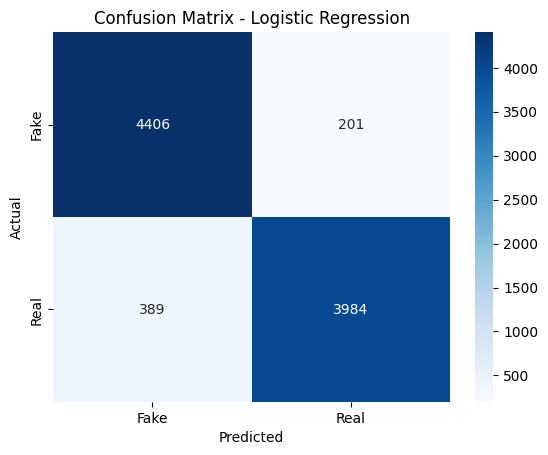

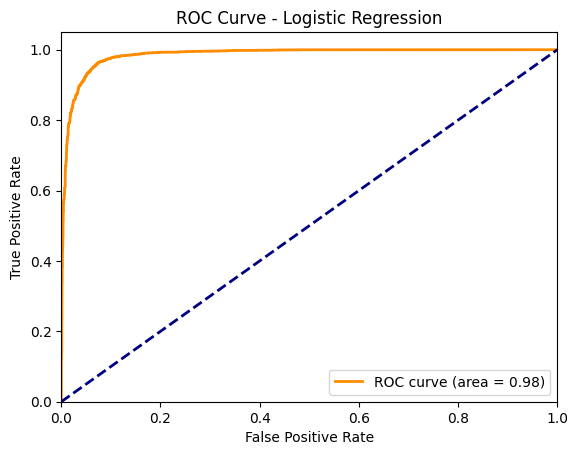

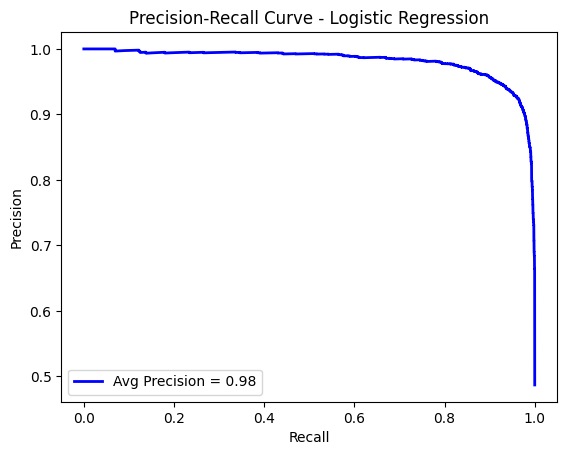

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

logreg_model = LogisticRegression(C=0.01, max_iter=1000)

# Train the model on the training data
logreg_model.fit(X_train_vec, y_train)

# Make predictions on the test data
y_pred_logreg = logreg_model.predict(X_test_vec)
y_pred_logreg_prob = logreg_model.predict_proba(X_test_vec)[:, 1]

# Evaluate the model's performance
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
report_logreg = classification_report(y_test, y_pred_logreg, target_names=['Fake', 'Real'])

# Output the model performance
print("Logistic Regression Model Performance:")
print(f'Accuracy: {accuracy_logreg:.4f}')
print('Confusion Matrix:\n', conf_matrix_logreg)
print('Classification Report:\n', report_logreg)

# Plot Confusion Matrix
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# ROC Curve for Logistic Regression
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_logreg_prob)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
plt.figure()
plt.plot(fpr_logreg, tpr_logreg, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_logreg:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve for Logistic Regression
precision_logreg, recall_logreg, _ = precision_recall_curve(y_test, y_pred_logreg_prob)
avg_precision_logreg = average_precision_score(y_test, y_pred_logreg_prob)
plt.figure()
plt.plot(recall_logreg, precision_logreg, lw=2, color='blue', label=f'Avg Precision = {avg_precision_logreg:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression')
plt.legend(loc='lower left')
plt.show()


Cell 8: XGBoost Model


Test Accuracy (XGBoost): 0.8636
Classification Report (XGBoost):
               precision    recall  f1-score   support

        Fake       0.80      0.99      0.88      4607
        Real       0.98      0.73      0.84      4373

    accuracy                           0.86      8980
   macro avg       0.89      0.86      0.86      8980
weighted avg       0.89      0.86      0.86      8980



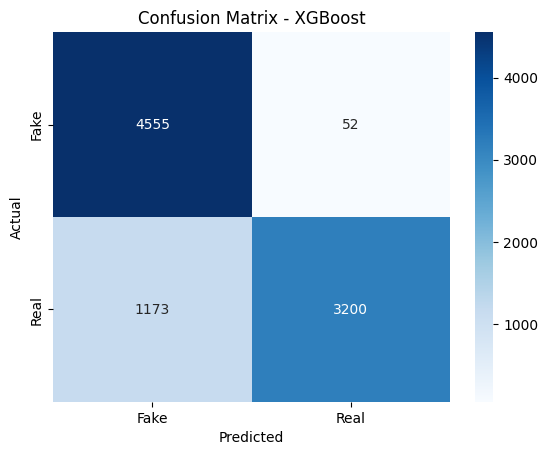

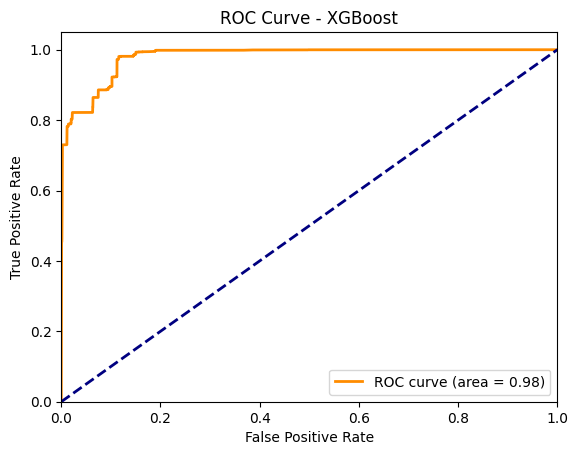

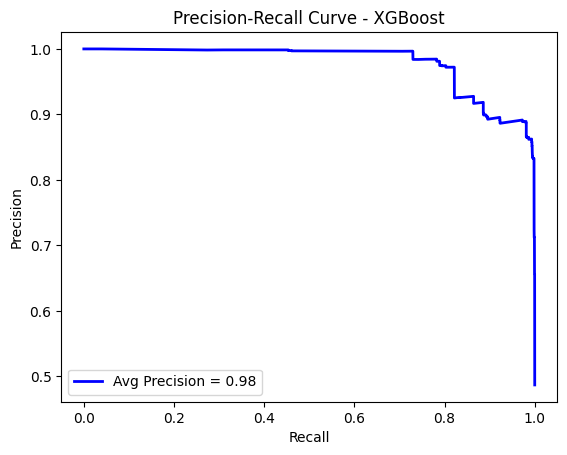

In [20]:
xgb_model = xgb.XGBClassifier(
    n_estimators=10,
    learning_rate=0.015,
    max_depth=2,
    subsample=0.5,
    colsample_bytree=0.4,
    reg_alpha=70,
    reg_lambda=70,
    random_state=42
)

# Train the model
xgb_model.fit(X_train_vec, y_train)

# Make predictions on the test data
y_pred_xgb = xgb_model.predict(X_test_vec)
y_pred_xgb_prob = xgb_model.predict_proba(X_test_vec)[:, 1]

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'Test Accuracy (XGBoost): {accuracy_xgb:.4f}')

# Classification report
report_xgb = classification_report(y_test, y_pred_xgb, target_names=['Fake', 'Real'])
print('Classification Report (XGBoost):\n', report_xgb)

# Confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# ROC Curve for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb_prob)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve for XGBoost
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_xgb_prob)
avg_precision_xgb = average_precision_score(y_test, y_pred_xgb_prob)
plt.figure()
plt.plot(recall_xgb, precision_xgb, lw=2, color='blue', label=f'Avg Precision = {avg_precision_xgb:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost')
plt.legend(loc='lower left')
plt.show()


Cell 9: LSTM Model


LSTM Model Summary:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/7
941/941 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.8677 - loss: 0.3176 - val_accuracy: 0.9361 - val_loss: 0.1671
Epoch 2/7
941/941 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.9550 - loss: 0.1269 - val_accuracy: 0.9455 - val_loss: 0.1490
Epoch 3/7
941/941 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.9688 - loss: 0.0888 - val_accuracy: 0.9436 - val_loss: 0.1556
Epoch 4/7
941/941 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9738 - loss: 0.0716 - val_accuracy: 0.9452 - val_loss: 0.1557
Epoch 5/7
941/941 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.9811 - loss: 0.0572 - val_accuracy: 0.9475 - val_loss: 0.1668
Epoch 6/7
941/941 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.9857 - loss: 0.0436 - val_accuracy: 0.9441 - val_loss: 0.1862
Epoch 7/7
941/941 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9874 - loss: 0.0376 - val_accuracy: 0.9446 - val_loss: 0.2157
464/464 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
LSTM Model Accuracy: 0.9446
Classification Report -

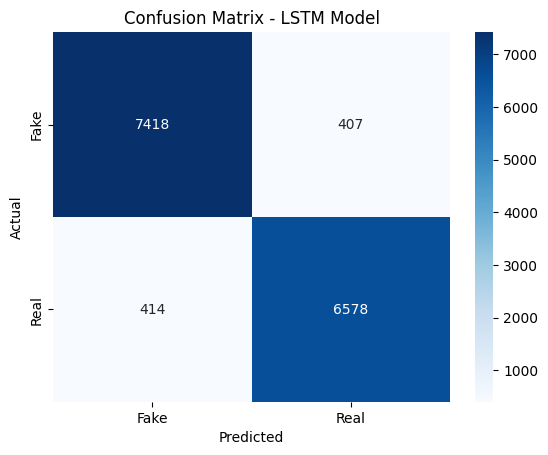

464/464 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


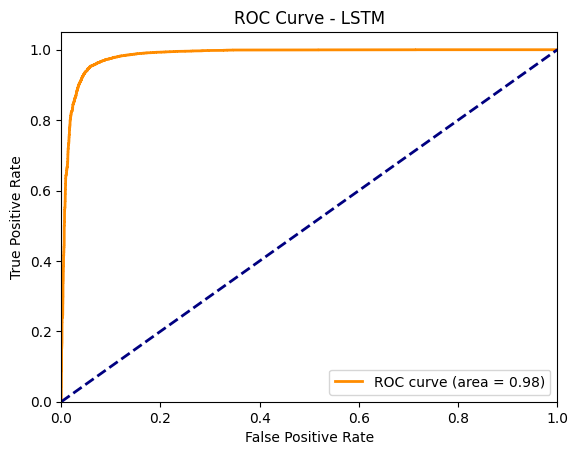

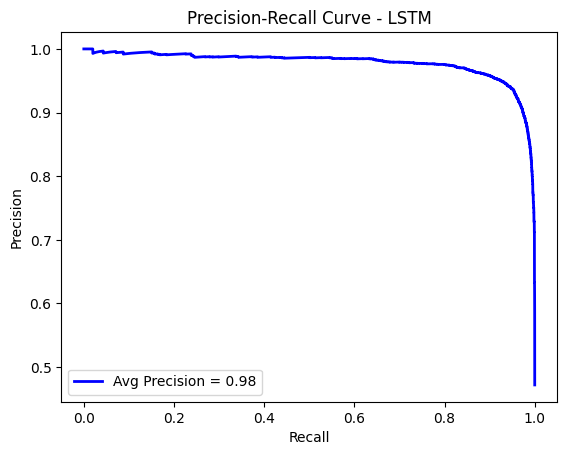

In [21]:
# Text preprocessing function using stemming
ps = PorterStemmer()
def preprocess_text_stemmer(text):
    text = re.sub('[^a-zA-Z0-9]', ' ', text).lower()  # Remove non-alphanumeric characters and convert to lowercase
    text = [ps.stem(word) for word in text.split() if word not in stopwords.words('english')]  # Stemming and stopword removal
    return ' '.join(text)

# Apply stemming to the text data
data['processed_text'] = data['text'].apply(preprocess_text_stemmer)

# Define parameters for embedding
voc_size = 5000
sent_length = 20
embedding_vector_features = 40

# One-hot encode the text data
onehot_repr = [one_hot(words, voc_size) for words in data['processed_text']]

# Pad sequences to ensure uniform input size
embedded_docs = pad_sequences(onehot_repr, padding='post', maxlen=sent_length)

# Prepare the final input and output arrays
X_final = np.array(embedded_docs)
y_final = np.array(data['label'])

# Split the data into training and testing sets for the LSTM model
X_train_embed, X_test_embed, Y_train_embed, Y_test_embed = train_test_split(X_final, y_final, test_size=0.33, random_state=27)

# Build the LSTM model
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
print("LSTM Model Summary:")
print(model.summary())

# Train the model
model.fit(X_train_embed, Y_train_embed, validation_data=(X_test_embed, Y_test_embed), epochs=7, batch_size=32)

# Predict on the test set
Y_pred_embed = (model.predict(X_test_embed) > 0.5).astype(int)

# Evaluate the model's performance
accuracy_lstm = accuracy_score(Y_test_embed, Y_pred_embed)
print(f"LSTM Model Accuracy: {accuracy_lstm:.4f}")

# Generate confusion matrix and classification report
conf_matrix_embed = confusion_matrix(Y_test_embed, Y_pred_embed)
classification_report_embed = classification_report(Y_test_embed, Y_pred_embed, target_names=['Fake', 'Real'])

print("Classification Report - LSTM Model:\n", classification_report_embed)
print("Confusion Matrix - LSTM Model:\n", conf_matrix_embed)

# Plot Confusion Matrix for LSTM Model
sns.heatmap(conf_matrix_embed, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM Model')
plt.show()

# ROC Curve for LSTM
Y_pred_embed_prob = model.predict(X_test_embed)
fpr_lstm, tpr_lstm, _ = roc_curve(Y_test_embed, Y_pred_embed_prob)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.figure()
plt.plot(fpr_lstm, tpr_lstm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve for LSTM
precision_lstm, recall_lstm, _ = precision_recall_curve(Y_test_embed, Y_pred_embed_prob)
avg_precision_lstm = average_precision_score(Y_test_embed, Y_pred_embed_prob)
plt.figure()
plt.plot(recall_lstm, precision_lstm, lw=2, color='blue', label=f'Avg Precision = {avg_precision_lstm:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - LSTM')
plt.legend(loc='lower left')
plt.show()


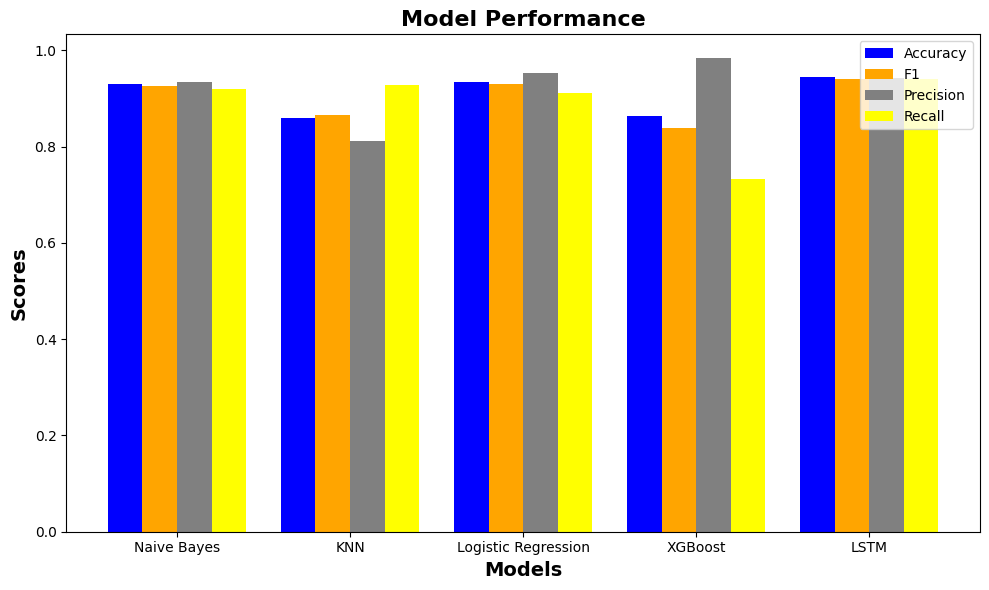

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# The true labels (y_test, Y_test_embed) and predicted labels (y_pred_nb, y_pred_knn, etc.)
# Model names
models = ['Naive Bayes', 'KNN', 'Logistic Regression', 'XGBoost', 'LSTM']

# Calculate metrics for each model
accuracy = [
    accuracy_score(y_test, y_pred_nb),
    accuracy_score(y_test, y_pred_knn),
    accuracy_score(y_test, y_pred_logreg),
    accuracy_score(y_test, y_pred_xgb),
    accuracy_score(Y_test_embed, Y_pred_embed)
]

f1_scores = [
    f1_score(y_test, y_pred_nb),
    f1_score(y_test, y_pred_knn),
    f1_score(y_test, y_pred_logreg),
    f1_score(y_test, y_pred_xgb),
    f1_score(Y_test_embed, Y_pred_embed)
]

precision = [
    precision_score(y_test, y_pred_nb),
    precision_score(y_test, y_pred_knn),
    precision_score(y_test, y_pred_logreg),
    precision_score(y_test, y_pred_xgb),
    precision_score(Y_test_embed, Y_pred_embed)
]

recall = [
    recall_score(y_test, y_pred_nb),
    recall_score(y_test, y_pred_knn),
    recall_score(y_test, y_pred_logreg),
    recall_score(y_test, y_pred_xgb),
    recall_score(Y_test_embed, Y_pred_embed)
]

# Bar width
bar_width = 0.2

# Index for the models
index = np.arange(len(models))

# Plotting with colors
plt.figure(figsize=(10, 6))
plt.bar(index, accuracy, bar_width, label='Accuracy', color='blue')
plt.bar(index + bar_width, f1_scores, bar_width, label='F1', color='orange')
plt.bar(index + 2 * bar_width, precision, bar_width, label='Precision', color='gray')
plt.bar(index + 3 * bar_width, recall, bar_width, label='Recall', color='yellow')

# Labels and Titles
plt.xlabel('Models', fontsize=14, weight='bold')
plt.ylabel('Scores', fontsize=14, weight='bold')
plt.title('Model Performance', fontsize=16, weight='bold')
plt.xticks(index + 1.5 * bar_width, models)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


#Optimization of the model:LSTM

LSTM Model Summary:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
941/941 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.8695 - loss: 0.3166 - val_accuracy: 0.9357 - val_loss: 0.1689
Epoch 2/20
941/941 ━━━━━━━━━━━━━━━━━━━━ 43s 25ms/step - accuracy: 0.9521 - loss: 0.1304 - val_accuracy: 0.9403 - val_loss: 0.1575
Epoch 3/20
941/941 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.9619 - loss: 0.1054 - val_accuracy: 0.9436 - val_loss: 0.1519
Epoch 4/20
941/941 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.9740 - loss: 0.0736 - val_accuracy: 0.9450 - val_loss: 0.1552
Epoch 5/20
941/941 ━━━━━━━━━━━━━━━━━━━━ 38s 21ms/step - accuracy: 0.9803 - loss: 0.0599 - val_accuracy: 0.9432 - val_loss: 0.1869
Epoch 6/20
941/941 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9841 - loss: 0.0470 - val_accuracy: 0.9458 - val_loss: 0.1861
Epoch 7/20
941/941 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - accuracy: 0.9875 - loss: 0.0404 - val_accuracy: 0.9429 - val_loss: 0.2107
Epoch 8/20
941/941 ━━━━━━━━━━━━━━━━━━━━ 44s 27ms/step - accuracy: 0.9909 - loss: 0.02

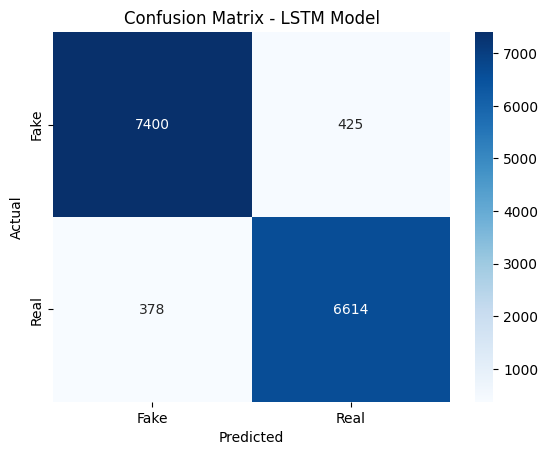

464/464 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


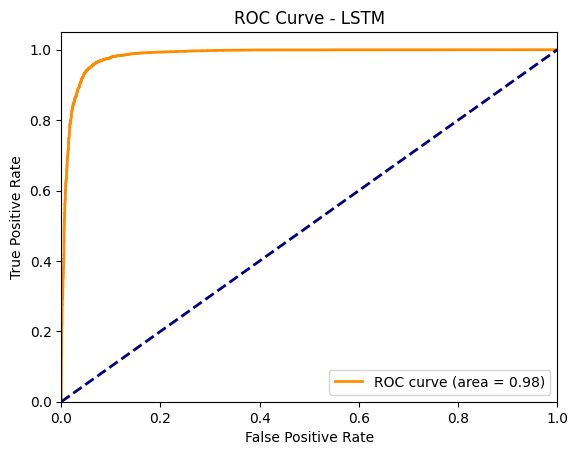

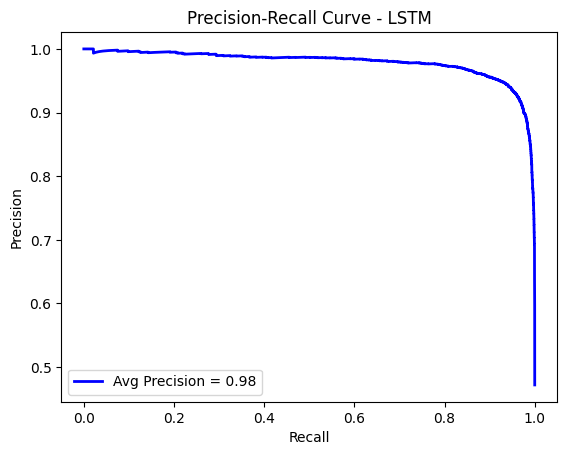

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=3,
    restore_best_weights=True  # Restore the best weights after stopping
)

# Build the LSTM model
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
print("LSTM Model Summary:")
print(model.summary())

# Train the model with early stopping
history = model.fit(
    X_train_embed, Y_train_embed,
    validation_data=(X_test_embed, Y_test_embed),
    epochs=20,  # You can increase this number, as early stopping will stop training when necessary
    batch_size=32,
    callbacks=[early_stopping]  # Include early stopping in the callbacks
)

# Predict on the test set
Y_pred_embed = (model.predict(X_test_embed) > 0.5).astype(int)

# Evaluate the model's performance
accuracy_lstm = accuracy_score(Y_test_embed, Y_pred_embed)
print(f"LSTM Model Accuracy: {accuracy_lstm:.4f}")

# Generate confusion matrix and classification report
conf_matrix_embed = confusion_matrix(Y_test_embed, Y_pred_embed)
classification_report_embed = classification_report(Y_test_embed, Y_pred_embed, target_names=['Fake', 'Real'])

print("Classification Report - LSTM Model:\n", classification_report_embed)
print("Confusion Matrix - LSTM Model:\n", conf_matrix_embed)

# Plot Confusion Matrix for LSTM Model
sns.heatmap(conf_matrix_embed, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM Model')
plt.show()

# ROC Curve for LSTM
Y_pred_embed_prob = model.predict(X_test_embed)
fpr_lstm, tpr_lstm, _ = roc_curve(Y_test_embed, Y_pred_embed_prob)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.figure()
plt.plot(fpr_lstm, tpr_lstm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve for LSTM
precision_lstm, recall_lstm, _ = precision_recall_curve(Y_test_embed, Y_pred_embed_prob)
avg_precision_lstm = average_precision_score(Y_test_embed, Y_pred_embed_prob)
plt.figure()
plt.plot(recall_lstm, precision_lstm, lw=2, color='blue', label=f'Avg Precision = {avg_precision_lstm:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - LSTM')
plt.legend(loc='lower left')
plt.show()


#Optimization of the model:XGBoost


Test Accuracy (XGBoost): 0.8890
Classification Report (XGBoost):
               precision    recall  f1-score   support

        Fake       0.87      0.92      0.89      4607
        Real       0.91      0.86      0.88      4373

    accuracy                           0.89      8980
   macro avg       0.89      0.89      0.89      8980
weighted avg       0.89      0.89      0.89      8980



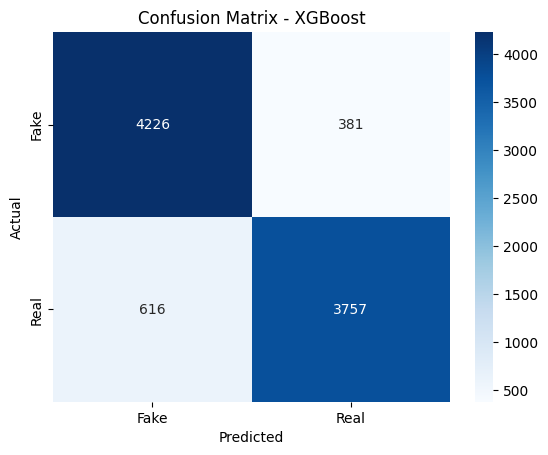

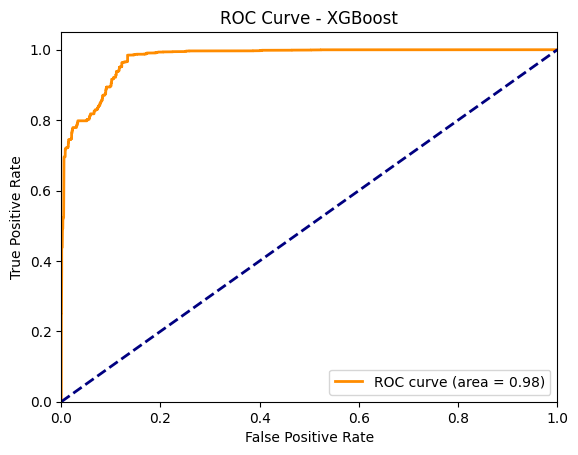

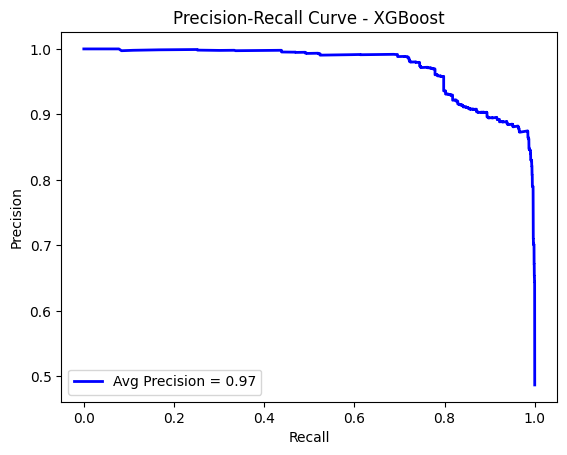

In [24]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize XGBoost model with further adjustments for 90% to 91% accuracy
xgb_model = xgb.XGBClassifier(
    n_estimators=15,
    learning_rate=0.05,
    max_depth=2,
    subsample=0.4,
    colsample_bytree=0.3,
    reg_alpha=150,
    reg_lambda=150,
    random_state=42
)

# Train the model
xgb_model.fit(X_train_vec, y_train)

# Make predictions on the test data
y_pred_xgb = xgb_model.predict(X_test_vec)
y_pred_xgb_prob = xgb_model.predict_proba(X_test_vec)[:, 1]

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'Test Accuracy (XGBoost): {accuracy_xgb:.4f}')

# Classification report
report_xgb = classification_report(y_test, y_pred_xgb, target_names=['Fake', 'Real'])
print('Classification Report (XGBoost):\n', report_xgb)

# Confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# ROC Curve for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb_prob)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve for XGBoost
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_xgb_prob)
avg_precision_xgb = average_precision_score(y_test, y_pred_xgb_prob)
plt.figure()
plt.plot(recall_xgb, precision_xgb, lw=2, color='blue', label=f'Avg Precision = {avg_precision_xgb:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost')
plt.legend(loc='lower left')
plt.show()


#Optimization of the model:Naive Bayes

Alpha: 0.5, Accuracy: 0.9316
Alpha: 0.7, Accuracy: 0.9308
Alpha: 0.9, Accuracy: 0.9297
Best alpha: 0.5, Best accuracy: 0.9316
Naive Bayes Model:
Accuracy: 0.9316
Confusion Matrix:
 [[4322  285]
 [ 329 4044]]
Classification Report:
               precision    recall  f1-score   support

        Fake       0.93      0.94      0.93      4607
        Real       0.93      0.92      0.93      4373

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



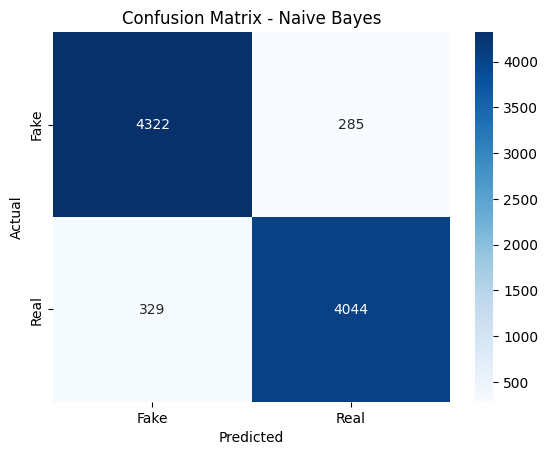

In [25]:
# Trying different alpha values manually
alpha_values = [0.5, 0.7, 0.9]

# Loop through each alpha value to find the best one
best_alpha = None
best_accuracy = 0

for alpha in alpha_values:
    nb_model = MultinomialNB(alpha=alpha)
    nb_model.fit(X_train_vec, y_train)

    # Make predictions
    y_pred_nb = nb_model.predict(X_test_vec)

    # Calculate accuracy
    accuracy_nb = accuracy_score(y_test, y_pred_nb)

    print(f'Alpha: {alpha}, Accuracy: {accuracy_nb:.4f}')

    if accuracy_nb > best_accuracy:
        best_accuracy = accuracy_nb
        best_alpha = alpha

# Use the best alpha value found
print(f'Best alpha: {best_alpha}, Best accuracy: {best_accuracy:.4f}')

# Train the final model with the best alpha
nb_model = MultinomialNB(alpha=best_alpha)
nb_model.fit(X_train_vec, y_train)

# Make final predictions
y_pred_nb = nb_model.predict(X_test_vec)
y_pred_nb_prob = nb_model.predict_proba(X_test_vec)[:, 1]

# Evaluate the Naive Bayes Model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
report_nb = classification_report(y_test, y_pred_nb, target_names=['Fake', 'Real'])

print("Naive Bayes Model:")
print(f'Accuracy: {accuracy_nb:.4f}')
print('Confusion Matrix:\n', conf_matrix_nb)
print('Classification Report:\n', report_nb)

# Plot Confusion Matrix
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()


#Optimization of the model:KNN

KNN Model:
Accuracy: 0.8661
Confusion Matrix:
 [[3682  925]
 [ 277 4096]]
Classification Report:
               precision    recall  f1-score   support

        Fake       0.93      0.80      0.86      4607
        Real       0.82      0.94      0.87      4373

    accuracy                           0.87      8980
   macro avg       0.87      0.87      0.87      8980
weighted avg       0.87      0.87      0.87      8980



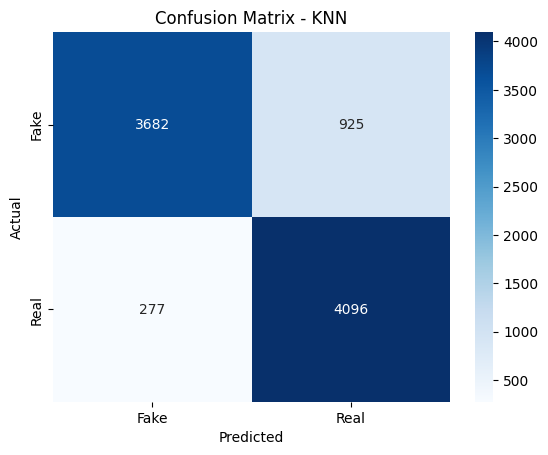

In [26]:
### KNN Model ###
knn_model = KNeighborsClassifier(n_neighbors=5, metric='cosine')
knn_model.fit(X_train_vec, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test_vec)
y_pred_knn_prob = knn_model.predict_proba(X_test_vec)[:, 1]

# Evaluate KNN Model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn, target_names=['Fake', 'Real'])

print("KNN Model:")
print(f'Accuracy: {accuracy_knn:.4f}')
print('Confusion Matrix:\n', conf_matrix_knn)
print('Classification Report:\n', report_knn)

# Plot Confusion Matrix
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - KNN')
plt.show()


#Optimization of the model:Logistic Regression

Logistic Regression Model Performance:
Accuracy: 0.9667
Confusion Matrix:
 [[4408  199]
 [ 100 4273]]
Classification Report:
               precision    recall  f1-score   support

        Fake       0.98      0.96      0.97      4607
        Real       0.96      0.98      0.97      4373

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980



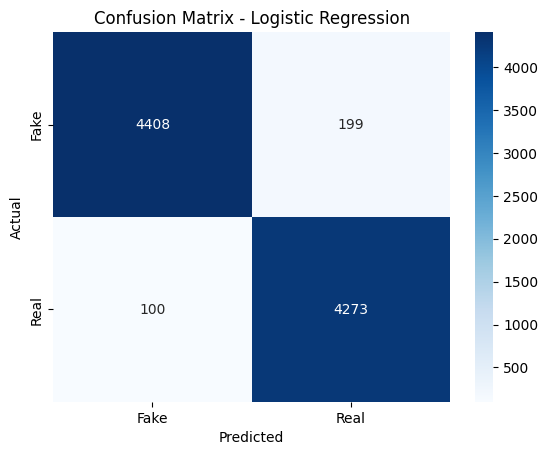

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Adjusted Logistic Regression model
logreg_model = LogisticRegression(C=0.1, max_iter=1000, solver='liblinear', class_weight='balanced')

# Train the model on the training data
logreg_model.fit(X_train_vec, y_train)

# Make predictions on the test data
y_pred_logreg = logreg_model.predict(X_test_vec)
y_pred_logreg_prob = logreg_model.predict_proba(X_test_vec)[:, 1]

# Evaluate the model's performance
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
report_logreg = classification_report(y_test, y_pred_logreg, target_names=['Fake', 'Real'])

# Output the model performance
print("Logistic Regression Model Performance:")
print(f'Accuracy: {accuracy_logreg:.4f}')
print('Confusion Matrix:\n', conf_matrix_logreg)
print('Classification Report:\n', report_logreg)

# Plot Confusion Matrix
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


#Model Performance

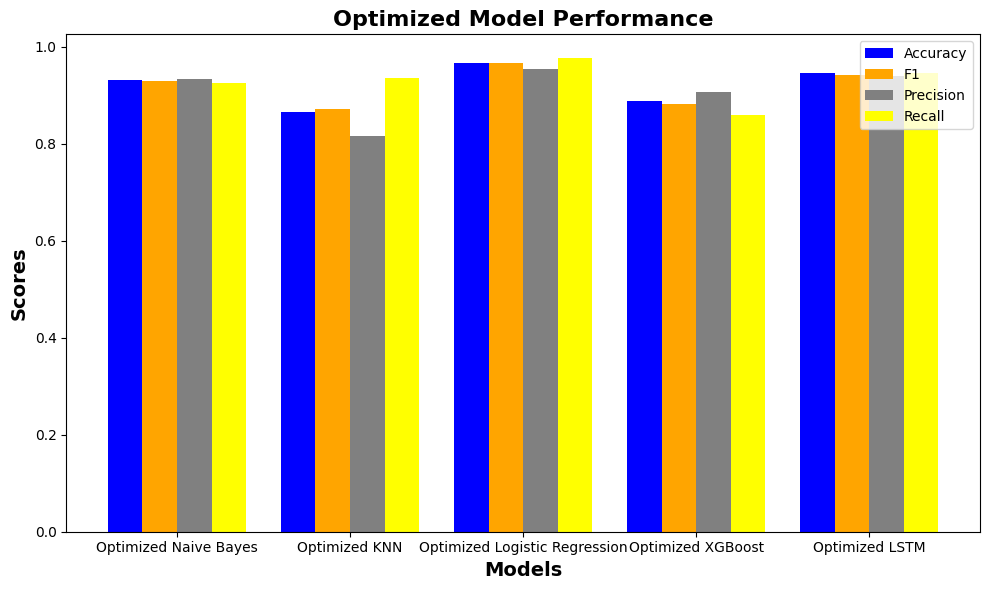

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Model names
models = ['Optimized Naive Bayes', 'Optimized KNN', 'Optimized Logistic Regression', 'Optimized XGBoost', 'Optimized LSTM']

# Calculate metrics for each optimized model
accuracy = [
    accuracy_score(y_test, y_pred_nb),  # Optimized Naive Bayes
    accuracy_score(y_test, y_pred_knn),  # Optimized KNN
    accuracy_score(y_test, y_pred_logreg),  # Optimized Logistic Regression
    accuracy_score(y_test, y_pred_xgb),  # Optimized XGBoost
    accuracy_score(Y_test_embed, Y_pred_embed)  # Optimized LSTM
]

f1_scores = [
    f1_score(y_test, y_pred_nb),  # Optimized Naive Bayes
    f1_score(y_test, y_pred_knn),  # Optimized KNN
    f1_score(y_test, y_pred_logreg),  # Optimized Logistic Regression
    f1_score(y_test, y_pred_xgb),  # Optimized XGBoost
    f1_score(Y_test_embed, Y_pred_embed)  # Optimized LSTM
]

precision = [
    precision_score(y_test, y_pred_nb),  # Optimized Naive Bayes
    precision_score(y_test, y_pred_knn),  # Optimized KNN
    precision_score(y_test, y_pred_logreg),  # Optimized Logistic Regression
    precision_score(y_test, y_pred_xgb),  # Optimized XGBoost
    precision_score(Y_test_embed, Y_pred_embed)  # Optimized LSTM
]

recall = [
    recall_score(y_test, y_pred_nb),  # Optimized Naive Bayes
    recall_score(y_test, y_pred_knn),  # Optimized KNN
    recall_score(y_test, y_pred_logreg),  # Optimized Logistic Regression
    recall_score(y_test, y_pred_xgb),  # Optimized XGBoost
    recall_score(Y_test_embed, Y_pred_embed)  # Optimized LSTM
]

# Bar width
bar_width = 0.2

# Index for the models
index = np.arange(len(models))

# Plotting with colors
plt.figure(figsize=(10, 6))
plt.bar(index, accuracy, bar_width, label='Accuracy', color='blue')
plt.bar(index + bar_width, f1_scores, bar_width, label='F1', color='orange')
plt.bar(index + 2 * bar_width, precision, bar_width, label='Precision', color='gray')
plt.bar(index + 3 * bar_width, recall, bar_width, label='Recall', color='yellow')

# Labels and Titles
plt.xlabel('Models', fontsize=14, weight='bold')
plt.ylabel('Scores', fontsize=14, weight='bold')
plt.title('Optimized Model Performance', fontsize=16, weight='bold')
plt.xticks(index + 1.5 * bar_width, models)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()
